In [47]:
from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.Chem import Descriptors, MACCSkeys
from rdkit.ML.Descriptors import MoleculeDescriptors

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from mordred import Calculator, descriptors

In [48]:
dataset = pd.read_excel("../data_for_modeling/hdac_edit_after_meeting.xlsx", sheet_name='original_data')
dataset.head()

,STT,Finder,AID,CID,SMILES,IC50 (uM),ACTIVITY,PP THU
0,116,Kim Anh,1548727,155525662,CC1=C(C2=CC=CC=C2N1)CCNCC3=CC=C(C=C3)C=CC(=O)N...,4.214,Active,Xét nghiệm huỳnh quang
1,810,Anh Thư,1762488,164629157,CSC1=CC2=C(C=C1)SC3=CC=CC=C3N2CC4=CC=C(C=C4)C(...,0.68,Active,xét nghiệm dựa trên huỳnh quang
2,83,Kim Anh,1765325,164627790,CCN1C(=NN=C1SCC2=CC=C(C=C2)C(=O)NC3=CC=CC=C3N)...,40.07,Unspecified,Xét nghiệm đầu đọc vi bản huỳnh quang
3,770,Anh Thư,1759721,164627737,CCCCC[C@@H](C1=NC=C(N1)C2=CC3=CC=CC=C3N=C2OC)N...,>40,Unspecified,xét nghiệm Steady-Glo luciferase
4,740,Anh Thư,1759719,164627737,CCCCC[C@@H](C1=NC=C(N1)C2=CC3=CC=CC=C3N=C2OC)N...,>17,Unspecified,xét nghiệm dựa trên huỳnh quang


## Cách xử lý ban đầu

### 1. Ultalities defined here

In [49]:
def append_dataframe(dataframe, row):
    dataframe.loc[len(dataframe.index)] = [row['STT'], row['Finder'], 
                                            row['AID'], row['CID'], row['SMILES'],
                                            row['IC50 (uM)'], row['ACTIVITY'], row['PP THU']]
    
def isfloat(num):
    try:
        if(num == 'NaN' or len(num) == 0):
            return False
        float(num)
        return True
    except ValueError:
        return False
isfloat('NaN')

False

### 2. Clean the data

In [90]:
# Using NumPy
active_inactive_rows = pd.DataFrame(columns = dataset.columns)
invalid_rows = pd.DataFrame(columns= dataset.columns)

#Rows for specific labels
active_rows = dataset.loc[dataset['ACTIVITY'] == "Active"]
inactive_rows = dataset.loc[dataset['ACTIVITY'] == "Inactive"]
inconclusive_rows = dataset.loc[dataset['ACTIVITY'] == "Inconclusive"]
unspecified_rows = dataset.loc[dataset['ACTIVITY'] == "Unspecified"]
cid_active = active_rows.loc[:, 'CID']
cid_unspec = unspecified_rows.loc[:, 'CID']
active_unspec_cid = np.intersect1d(cid_active, cid_unspec)
print("unspecified rows len before: " + str(len(unspecified_rows)) )
#Filter out unspecified
for cid in active_unspec_cid:
    rows = unspecified_rows[unspecified_rows.CID == cid]
    invalid_rows = invalid_rows.append(rows)
    unspecified_rows = unspecified_rows.drop(rows.index)
    
print("unspecified rows len after: " + str(len(unspecified_rows)) )

unspecified rows len before: 268
unspecified rows len after: 247


In [91]:
invalid_rows = invalid_rows.append(inconclusive_rows)
print(len(active_rows))
print(len(inactive_rows))
print(len(invalid_rows))

1090
10
71


### 3. Duplicate filter

In [92]:
final_columns = ["STT", "SMILES", "CID", "AVG_IC50_uM", "FIRST_LABEL", "FINAL_LABEL", "DUPLICATE_COUNTS"]
final_rows = pd.DataFrame(columns=final_columns)
stt = 0
for cid in active_rows.CID.unique():
    sub_dataset = active_rows.loc[active_rows.CID == cid]
    avg_ic50, dup_count = 0, 0
    for index, row in sub_dataset.iterrows():
        avg_ic50 = avg_ic50 + float(row["IC50 (uM)"])/len(sub_dataset)
        dup_count = dup_count + 1
    final_rows.loc[len(final_rows)] = [stt, row.SMILES, row.CID ,avg_ic50, 'Active',
                                        {True: 'Active', False: 'Inactive'} [avg_ic50 < 1],
                                        dup_count]
    stt = stt + 1

In [93]:
final_rows1 = pd.DataFrame(columns=final_columns)
for cid in inactive_rows.CID.unique():
    sub_dataset = inactive_rows.loc[inactive_rows.CID == cid]
    avg_ic50, dup_count = 0, 0
    for index, row in sub_dataset.iterrows():
        avg_ic50 = avg_ic50 + float(row["IC50 (uM)"])/len(sub_dataset)
        dup_count = dup_count + 1
    final_rows1.loc[len(final_rows1)] = [stt, row.SMILES, row.CID ,avg_ic50, 'Inactive',
                                        "Inactive",
                                        dup_count]

In [94]:
len(unspecified_rows)

247

In [95]:
final_rows2 = pd.DataFrame(columns=final_columns)
for cid in unspecified_rows.CID.unique():
    sub_dataset = unspecified_rows.loc[unspecified_rows.CID == cid]
    dup_count = 0
    for index, row in sub_dataset.iterrows():
        dup_count = dup_count + 1
    final_rows2.loc[len(final_rows2)] = [stt, row.SMILES, row.CID ,'', 'Unspecified',
                                        "Inactive",
                                        dup_count]

In [96]:
final_data_to_train = pd.DataFrame(columns=final_columns)
print("Before appends: " + str(len(final_data_to_train)))
final_data_to_train = final_data_to_train.append(final_rows)
final_data_to_train = final_data_to_train.append(final_rows1)
final_data_to_train = final_data_to_train.append(final_rows2)
print("After appends: " + str(len(final_data_to_train)))

Before appends: 0
After appends: 993


## Write to file

In [97]:
with pd.ExcelWriter("../data_for_modeling/HDAC2_data_after_filtering_raw.xlsx") as writer:
    dataset.to_excel(writer, sheet_name="Dữ liệu ban đầu", index=False)
    invalid_rows.to_excel(writer, sheet_name="Dữ liệu không hợp lệ", index=False)
    final_data_to_train.to_excel(writer, sheet_name="Dữ liệu sau khi lọc", index=False)

### Đánh giá bộ dữ liệu

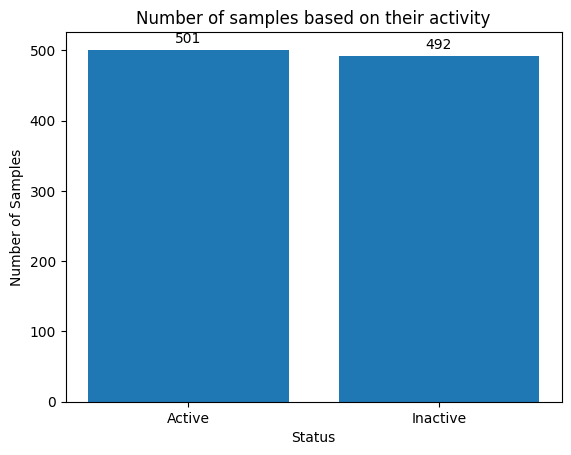

In [112]:
import matplotlib.pyplot as plt

# Define the data
labels = ['Active', 'Inactive']
values = [len(final_data_to_train.loc[final_data_to_train.FINAL_LABEL == "Active"]), len(final_data_to_train.loc[final_data_to_train.FINAL_LABEL == "Inactive"])]

# Create the bar chart
plt.bar(labels, values)

# Add labels on top of each column
for i, v in enumerate(values):
    plt.text(i, v + 10, str(v), ha='center')

# Set chart title and labels
plt.title('Number of samples based on their activity')
plt.xlabel('Status')
plt.ylabel('Number of Samples')

# Display the chart
plt.show()

In [113]:
dup_count_unique = final_data_to_train.DUPLICATE_COUNTS.unique()
dup_count_numbers = []
for dup_count_number in dup_count_unique:
    sub_dataset = final_data_to_train.loc[final_data_to_train.DUPLICATE_COUNTS == dup_count_number]
    dup_count_numbers.append(len(sub_dataset))
print(dup_count_unique)
print(dup_count_numbers)

[1 4 2 3 6 5 9 94 31]
[831, 5, 120, 27, 2, 4, 2, 1, 1]


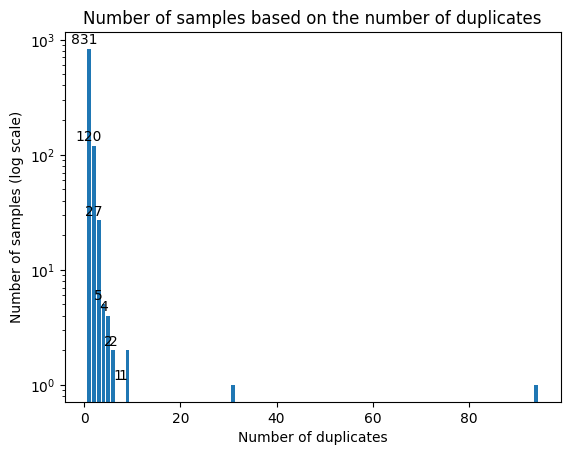

In [114]:
import matplotlib.pyplot as plt

# Define the data
labels = [1, 4, 2, 3, 6, 5, 9, 94, 31]
values = [831, 5, 120, 27, 2, 4, 2, 1, 1]

# Sort the data by labels
labels, values = zip(*sorted(zip(labels, values)))

# Create the bar chart with log scale
plt.bar(labels, values)
plt.yscale('log')

# Add labels on top of each column
for i, v in enumerate(values):
    plt.text(i, v * 1.1, str(v), ha='center')

# Set chart title and labels
plt.title('Number of samples based on the number of duplicates')
plt.xlabel('Number of duplicates')
plt.ylabel('Number of samples (log scale)')

# Display the chart
plt.show()